**(S)ARIMA univariate model for the prediction of meteorological time series data.**

# **IMPORT LIBRARIES**

In [22]:
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt

from math import sqrt
from pandas import DataFrame
from datetime import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.ar_model import AutoReg # AR
from statsmodels.tsa.arima.model import ARIMA #ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, mean_absolute_percentage_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('default')

# **DATA MANIPULATION**

In [23]:
#--- LOAD DATA ---#
location = 'TIME-SERIES-Diario-13-23.csv'  ## DAILY DATA
# location = 'TIME-SERIES-Mensual-86-23.csv' ## MONTHLY DATA

data = pd.read_csv(location, delimiter=',', index_col='Fecha', header=0, parse_dates=True)
data.head()

,Año,Mes,Dia,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
Fecha,,,,,,,,
2013-01-01,2013,Ene,1,12.038,18.022,7.344,0.956,73.676
2013-01-02,2013,Ene,2,12.224,18.000,8.078,3.600,74.553
2013-01-03,2013,Ene,3,11.902,17.822,7.667,9.933,76.719
2013-01-04,2013,Ene,4,10.906,16.778,7.122,8.800,79.117
2013-01-05,2013,Ene,5,11.146,16.267,7.211,4.956,79.746


In [24]:
# RENAME COLUMNS NAME
data = data.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad"})

In [25]:
#--- SELECT TARGET VARIABLE ---#
# We are dropping all columns except 'Temp_max' to isolate the target variable.
data = data.drop(["Año", "Dia", "Mes", "Temp_media", "Humedad", "Precipitacion", "Temp_min"], axis=1) # DAILY MAXIMUM TEMPERATURE DATA FRAME
# data = data.drop(["Año", "Mes", "Temp_media", "Humedad", "Temp_min", "Precipitacion"], axis=1)# # MONTHLY MAXIMUM TEMPERATURE DATA FRAME

# Display the first few rows of the dataframe after dropping columns
data.head()

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000
2013-01-03,17.822
2013-01-04,16.778
2013-01-05,16.267


In [26]:
#Check for null values
data.isnull().any()

,0
Temp_max,False


In [27]:
# DROP NULL VALUES
data.dropna(inplace=True)

In [28]:
# DATA SET INFORMATION
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3883 entries, 2013-01-01 to 2023-08-19
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Temp_max  3883 non-null   float64
dtypes: float64(1)
memory usage: 60.7 KB


In [29]:
# Basic descriptive stats
data.describe()

,Temp_max
count,3883.000000
mean,18.019176
std,2.143404
min,6.000000
25%,16.700000
50%,18.100000
75%,19.400000
max,24.900000


# **DATA PREPARATION**

## **DATA SPLIT**

In [30]:
# split into train and test sets
X = data
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [31]:
train.head(2)

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000


In [32]:
test.head(2)

,Temp_max
Fecha,
2021-07-04,18.6
2021-07-05,18.8


# **MODEL SETUP**

In [33]:
#@title SARIMA Configuration
model = SARIMAX(train['Temp_max'], order=(2, 0, 1),seasonal_order=(2,1,2,15))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [34]:
#@title Model Train
model = model.fit()

In [35]:
#@title SARIMA summary
# summary of fit model
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                Temp_max   No. Observations:                 3106
Model:             SARIMAX(2, 0, 1)x(2, 1, [1, 2], 15)   Log Likelihood               -6103.067
Date:                                 Tue, 15 Jul 2025   AIC                          12222.134
Time:                                         16:40:18   BIC                          12270.424
Sample:                                     01-01-2013   HQIC                         12239.477
                                          - 07-03-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4406      0.022     66.988      0.000       1.398       1

In [36]:
#@title SARIMA Prediction
# Prediction
pred_SARIMA = model.predict(len(train.Temp_max),len(test.Temp_max)+len(train.Temp_max)-1)
print(pred_SARIMA)

2021-07-04    17.641439
2021-07-05    17.416141
2021-07-06    17.443476
2021-07-07    17.554880
2021-07-08    17.392409
                ...    
2023-08-15    17.761590
2023-08-16    17.730439
2023-08-17    17.921813
2023-08-18    18.003457
2023-08-19    17.980705
Freq: D, Name: predicted_mean, Length: 777, dtype: float64


In [37]:
#@title SARIMA Evaluation
# Calculate the metrics
mae = mean_absolute_error(test['Temp_max'], pred_SARIMA)
rmse = mean_squared_error(test['Temp_max'], pred_SARIMA) ** 0.5
mse = mean_squared_error(test['Temp_max'], pred_SARIMA)
mape = mean_absolute_percentage_error(test['Temp_max'], pred_SARIMA) * 100

# PRINT METRICS
print(f'TEST - RMSE: {rmse:.5f}, MAE: {mae:.5f}, MAPE: {mape:.5f}%')

TEST - RMSE: 2.29395, MAE: 1.80132, MAPE: 9.89940%


# **VISUALIZATION**

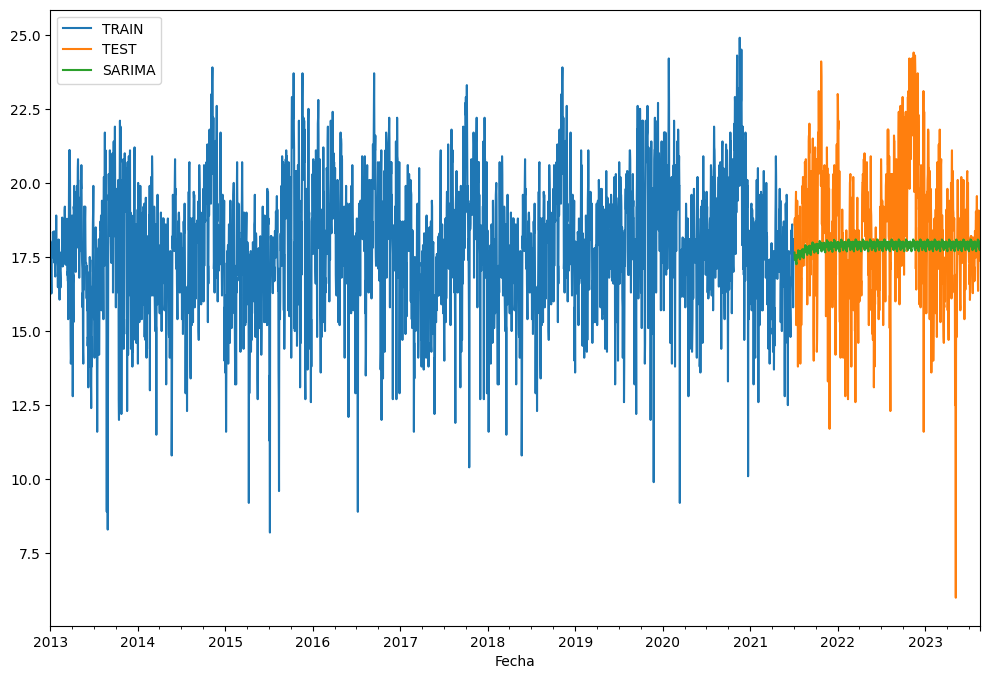

In [38]:
# PLOT FORECASTING
train['Temp_max'].plot(legend=True, label='TRAIN')
test['Temp_max'].plot(legend=True, label='TEST', figsize=(12,8))
pred_SARIMA.plot(legend=True, label='SARIMA');

<Axes: xlabel='Fecha'>

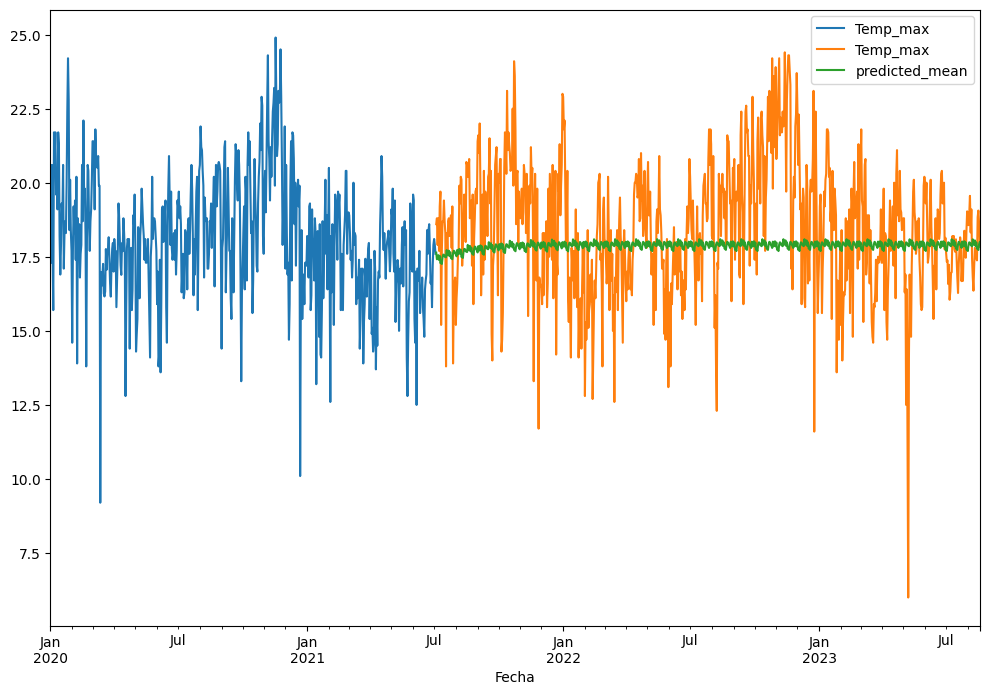

In [39]:
# Close Visualization
train['Temp_max']['2020-01-01':].plot(figsize = (12,8), legend = True)
test['Temp_max'].plot( legend = True)
pred_SARIMA.plot(legend = True)

# **FUTURE PREDICTIONS**

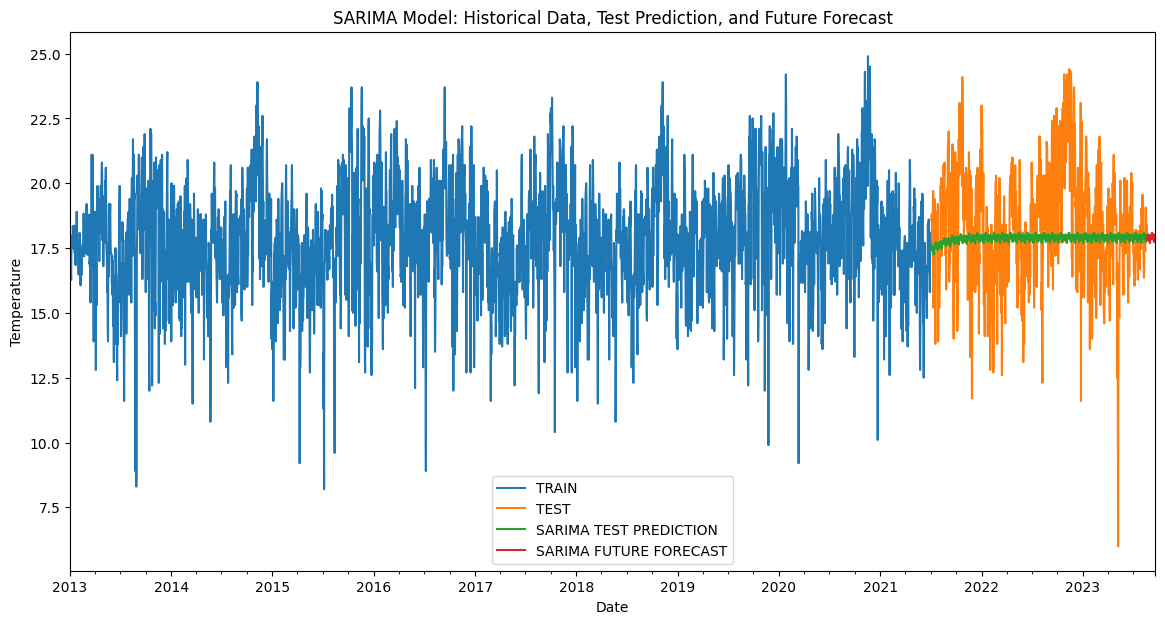

In [43]:
# # prompt: I WANTO TO MAKE FUTURE PREDICTIONS LIKE FORECAST TO THE FUTURE FROM THE LAS DAY OR VALUE OF THE DATA SET (FUTURE PREDICTION)

# # Forecast into the future
# future_steps = 30  # Number of future days to predict
# future_forecast = model.predict(start=len(data), end=len(data) + future_steps - 1)

# # Create a date index for the future predictions
# last_date = data.index[-1]
# future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq=data.index.freq)[1:] # Add 1 because start is inclusive

# # Convert the future forecast to a pandas Series with the new date index
# future_forecast_series = pd.Series(future_forecast, index=future_dates)

# # Plot the historical data, test data, and the future forecast
# plt.figure(figsize=(14, 7))
# train['Temp_max'].plot(legend=True, label='TRAIN')
# test['Temp_max'].plot(legend=True, label='TEST')
# pred_SARIMA.plot(legend=True, label='SARIMA TEST PREDICTION')
# future_forecast_series.plot(legend=True, label='SARIMA FUTURE FORECAST')
# plt.title('SARIMA Model: Historical Data, Test Prediction, and Future Forecast')
# plt.xlabel('Date')
# plt.ylabel('Temperature')
# plt.show()


In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def forecast_sarima(model_fit, original_series, steps, conf_int=True, alpha=0.05,
                    label_hist='Histórico', label_fore='Pronóstico'):
    """
    Devuelve y opcionalmente grafica un pronóstico SARIMA.

    Parámetros
    ----------
    model_fit : SARIMAXResults / ARIMAResults
    original_series : pd.Series (índice datetime)
    steps : int  – horizonte
    conf_int : bool – dibujar intervalo de confianza
    alpha : float – nivel de significancia (0.05 ⇒ 95 %)
    """

    # 1. Predicción
    if conf_int:
        res = model_fit.get_forecast(steps=steps)
        y_pred = res.predicted_mean
        ci = res.conf_int(alpha=alpha)
    else:
        y_pred = model_fit.forecast(steps=steps)

    # 2. Índice futuro
    last_date = original_series.index[-1]
    # Infer frequency if not set
    freq = original_series.index.freq
    if freq is None:
        freq = pd.infer_freq(original_series.index)

    future_idx = pd.date_range(
        last_date + pd.tseries.frequencies.to_offset(freq), periods=steps, freq=freq
    )
    y_pred.index = future_idx
    if conf_int:
        ci.index = future_idx

    # 3. Plot simple
    plt.figure(figsize=(14, 6))
    original_series.plot(label=label_hist)
    y_pred.plot(style='--o', label=label_fore)
    if conf_int:
        plt.fill_between(future_idx, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3)
    plt.legend()
    plt.title(f'{label_fore} ({steps} pasos)')
    plt.show()

    return y_pred, (ci if conf_int else None)

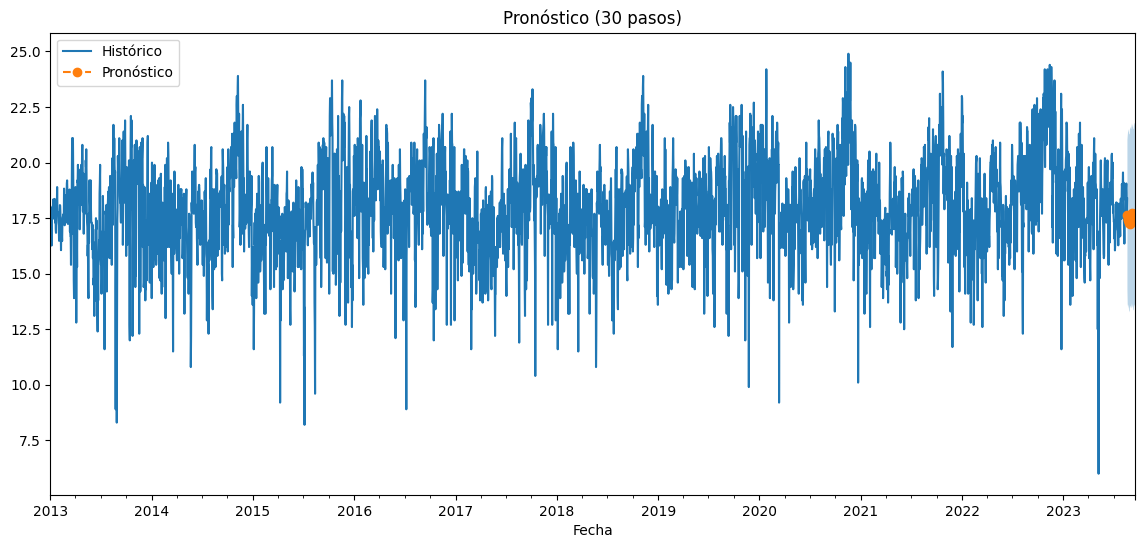

In [47]:
pred_30d, ci_30d = forecast_sarima(model, data['Temp_max'], steps=30)

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import to_offset

def forecast_sarima(model_fit, original_series, steps,
                    freq=None,                     # <- NUEVO
                    conf_int=True, alpha=0.05,
                    label_hist='Histórico', label_fore='Pronóstico'):

    # 0️⃣  Determinar frecuencia
    if freq is None:
        freq = original_series.index.freq or pd.infer_freq(original_series.index)
    if freq is None:
        raise ValueError("No se pudo inferir la frecuencia; pásala con freq='D', 'M', …")

    # 1️⃣  Predicción
    if conf_int:
        res = model_fit.get_forecast(steps=steps)
        y_pred = res.predicted_mean
        ci = res.conf_int(alpha=alpha)
    else:
        y_pred = model_fit.forecast(steps=steps)

    # 2️⃣  Índice futuro
    last_date = original_series.index[-1]
    future_idx = pd.date_range(last_date + to_offset(freq),
                               periods=steps, freq=freq)
    y_pred.index = future_idx
    if conf_int:
        ci.index = future_idx

    # 3️⃣  Gráfico simple
    plt.figure(figsize=(14, 6))
    original_series.plot(label=label_hist)
    y_pred.plot(style='--o', label=label_fore)
    if conf_int:
        plt.fill_between(future_idx, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.3)
    plt.title(f'{label_fore} ({steps} pasos)')
    plt.legend()
    plt.show()

    return y_pred, (ci if conf_int else None)

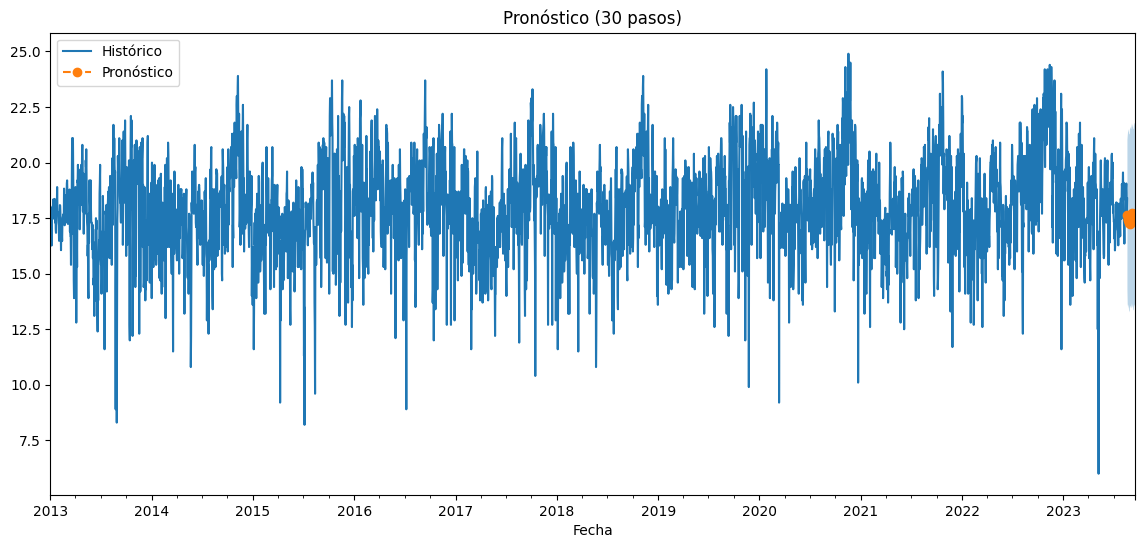

In [49]:
pred_30d, ci_30d = forecast_sarima(
    model_fit=model,
    original_series=data['Temp_max'],
    steps=30,
    freq='D'          # ← aquí le dices la frecuencia
)